v1.42, 14 January 2023, by Brian Fiedler

tested to work with Anaconda Python 3.7

 * [Basemap is obsolete](https://matplotlib.org/basemap/), and removed from this notebook.  No drawing of coastlines on the plots. 

 * An alternative to netcdf4 data is included, if netcdf4 does not work for you.

 * Because of all the images produced, this notebook may take about a minute to run. 

# netCDF data of Sea Surface Temperature

Here we will investigate 24 months of monthly-averaged Sea Surface Temperature data, for years 2001 and 2002. 
All 24 months can be visualized here: http://metr4330.net/~bfiedler/sst.html
  
  
You will need the netCDF data file [tos_O1_2001-2002.nc](http://www.unidata.ucar.edu/software/netcdf/examples/tos_O1_2001-2002.nc).  You can also [download it from my website](http://metr4330.net/data/tos_O1_2001-2002.nc).
The file is one of several offered in
[Example netCDF files](http://www.unidata.ucar.edu/software/netcdf/examples/files.html).
  
There is nothing particularly special or amazing about this data.
But it is small and easy to use. And it does show an "El Nino" event in 2002.

The data file was analyzed in a task in [METR 1313](http://metr1313.metr4330.net/lessons/GriddedData), which you should study a bit.  Here we expand on what was in METR 1313, showing off the benefits of working with an ipython notebook.

We will refer to the average of temperature conditions in January 2001  and January 2002 as defining a "climate" for January.
Normally, climate averages require more than just an average of two values.  Often approximately 30 Januarys would be required to truly define a "climate" for January.
But in this educational exercise we keep the data small.  Use your imagination a bit about how your computations would 
be very similar if there were many more years in the data.  

When we look at the difference between the data for a month and the climate defined for a month, that
gives the `anomaly`.  Our short data does show a very meaningful anomaly, [an ENSO cycle](http://oceanservice.noaa.gov/facts/ninonina.html)

You should examine my [numpy arrays tutorial](http://metr1313.metr4330.net/lessons/arrays) before proceeding with this project. You can do that tutorial by
just typing the examples into a new ipython notebook.




In [2]:
%%html
<style> div.text_cell_render{background-color: #ded; font-size: 18px}
                    .rendered_html code {background-color: #ded; color: #900; font-size: 16px}
                    .rendered_html pre {background-color: #ded; color: #900; font-size: 16px} 
</style>

# Preparing Anaconda Python

If `import netCDF4` produces an error in your python, you may need to do the following for your Anaconda installation.

On your Linux or OSX terminal, or Windows Anaconda Prompt enter:

```
conda update conda
conda update anaconda
conda install netcdf4
```
With Anaconda Python 3.7, that should work for you. 

In [4]:
import os
import subprocess
from netCDF4 import Dataset # if not working, comment out, and see alternative below
import numpy as np
import matplotlib.pyplot as plt
import warnings


If you are interested: [pcolormesh](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.pcolormesh.html). We use it within `plotpixels2`:

In [6]:
# This is our plotting function. You don't need to understand it.
# No documentation is offered here. Just note the examples following.
def plotpixels2(lon1d,lat1d,data,lowc=None,hic=None,title=None,signature="",
         startlon=0.,outfile=None,caption=None,dpi=144,sizemult=1):
    print('...doing plotpixels:')

# Must specify the coordinates of the 4 points of the rectangle surrounding each pixel:
    lon1d=np.array(lon1d)
    lat1d=np.array(lat1d)
    delon = lon1d[1]-lon1d[0]
    delat = lat1d[1]-lat1d[0]
    lonp = np.zeros(len(lon1d)+1,'d') # size is 1 longer than lon1d
    latp = np.zeros(len(lat1d)+1,'d') # size is 1 longer than lat1d
    lonp[0:len(lon1d)] = lon1d-0.5*delon
    lonp[-1] = lon1d[-1]+0.5*delon
    latp[0:len(lat1d)] = lat1d-0.5*delat
    latp[-1] = lat1d[-1]+0.5*delat
    lons, lats = np.meshgrid(lonp, latp) # mysterious numpy... lons and lats are 2D

    aspectRatio=.5

    xsize = sizemult*plt.rcParams['figure.figsize'][0]
    fig = plt.figure(figsize=(xsize,aspectRatio*xsize))
    ax = fig.add_axes([0.08,0.1,0.7,0.7],facecolor='white') # changed to facecolor 8 October 2019


    colormap=plt.cm.jet

# Pixelate your data!:

    p = plt.pcolormesh(lons,lats,data,cmap=colormap) #note: shape of lons and lats are +1 of data


    if title: plt.title(title)
    cax = plt.axes([0.85, 0.1, 0.05, 0.7]) # setup colorbar axes
    datamin=data.min()
    datamax=data.max()
    if lowc==None : lowc=datamin
    if hic==None : hic=datamax
    print('min data: ',datamin,'   max data:',datamax)
    print('low color bound:',lowc,'  high color bound:',hic)
    if  datamin<lowc:
        print("warning: some data below low color bound ")
    if datamax>hic:
        print("warning: some data above high color bound")
    if datamax>1000.:
        plt.colorbar(format='%7.1e', cax=cax) # draw colorbar
    elif datamax>5.:
        plt.colorbar(format='%d', cax=cax) # draw colorbar
    else:
        plt.colorbar(format='%5.2f', cax=cax) # draw colorbar
    plt.axes(ax)  # make the original axes current again
    plt.clim(lowc,hic)

    plt.axis( [ lonp[0], lonp[-1], latp[0], latp[-1] ] )
    if caption: 
        plt.text(-.1,-.15,caption,fontsize=10, transform = plt.gca().transAxes)
    if signature:
        plt.text(-.1,0.,signature,fontsize=48, alpha=.1, transform = plt.gca().transAxes)
    if outfile != None:
        plt.savefig(outfile, dpi=dpi, facecolor='w', edgecolor='w', orientation='portrait')
        print('saved plot to ',outfile,'\n')
        plt.show()
        plt.close()

## Read the gridded data into a numpy array

If the netCDF4 module is NOT working for you, the next two cells should
be replaced with the alternative described below.

In [8]:
ncpath = 'tos_O1_2001-2002.nc' # path to the netCDF data file
ncfile = Dataset(ncpath, 'r') # make a file handle to read the file

We copy variable ```tos``` ("temperature of sea") into numpy array `sst` ("sea surface temperature")

In [10]:

warnings.filterwarnings("ignore", category=DeprecationWarning) # comment out, if you want warnings

sst =   ncfile.variables['tos'][:].astype('float64') 
print("shape of sst:", sst.shape, "   sample:",sst[12,100,100])
lon1d = ncfile.variables['lon'][:] # longitude, 1-D array
print("shape of lon1d:", lon1d.shape,"   sample:",lon1d[100]) 
lat1d = ncfile.variables['lat'][:] # latitude, 1-D array
print("shape of lat1d:", lat1d.shape,"  sample:",lat1d[100])

shape of sst: (24, 170, 180)    sample: 298.7950744628906
shape of lon1d: (180,)    sample: 201.0
shape of lat1d: (170,)   sample: 20.5


#### If netCDF4 did not work for you:
* Get the data files explicitly for python, as numpy arrays,  from the this link: [data as numpy arrays](http://metr4330.net/archive/tos_as_numpy_arrays/)
* I have set the cell below to "raw". Highlight in blue (command mode) and
* enter letter ```y```, to turn it into executable python. 
(turn it back to raw by entering letter ```r```)
* In the following, the enormously big numbers are meant to be masked, because it is land. netCDF4 made the mask automatically. In the following, the mask is made manually, where the big numbers are.

*Really important step!* We make the arrays `climate` and `anomaly` from `sst`.  This requires some cleverness with numpy:

In [13]:
climate = 0.5*( sst[0:12,:,:] + sst[12:,:,:] ) #average the two years
anomaly = sst.copy() # below, we subtract climate
anomaly[0:12,:,:] -= climate # subtract climate from first year
anomaly[12:,:,:] -= climate  # subtract climate from second year

# The seven 2-D plots from METR 1313
`sst`, `climate` and `anomaly` are 3-D arrays.  The first index selects a month. 
For example `data2d = sst[0,:,:]` selects the first month, `data2d = sst[1,:,:]`
selects the second month. We can also extract a 2-D array by specifying a latitude index, such as in 
`data2d = anomaly[:,80,:]` This takes a slice at latitude 0.5 N (very near the equator), as revealed by `lat1d[80]`.
Plotting such 2-D slices makes a [Hovmöller diagram](https://en.wikipedia.org/wiki/Hovm%C3%B6ller_diagram).

In [15]:
pdir = "bunchofplots/" # name of subdirectory to output plot files into
if not os.path.exists(pdir): os.mkdir(pdir)

In [16]:
# This function was used for METR 1313 students, 
# to signal to them that they were correct. I will
# leave it here for fun.
def iwant(myval,target):
    print(myval,end="")
    if .999999*target < myval < target*1.000001:
        print("  Value correct!")
    else:
        print("  Wrong! You missed the target:",target)

301.947509765625  Value correct!
...doing plotpixels:
min data:  271.1732482910156    max data: 304.6780090332031
low color bound: 270   high color bound: 305
saved plot to  bunchofplots/Jan2001.png 



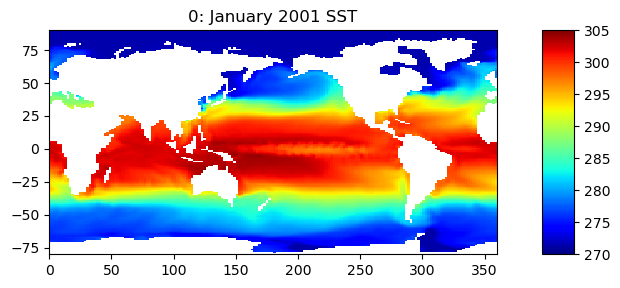

In [17]:
mytitle="0: January 2001 SST"
data2d = sst[0,:,:] 
iwant( data2d[85,100] , 301.947509766 )

# plotpixels requires: the x coordinates 1-D array,
# the y coordinates 1-D array, a data2d 2-D array,
# with the y-index first (latitude direction) and 
# the x-index second (longitude).
# hic sets the value mapped to the highest color, 
# lowc sets the value mapped to the lowest color
plotpixels2(lon1d, lat1d, data2d, hic=305, lowc=270,
        title = mytitle, outfile=pdir+'Jan2001.png')

1.483642578125  Value correct!
...doing plotpixels:
min data:  -2.911102294921875    max data: 2.911102294921875
low color bound: -2.911102294921875   high color bound: 2.911102294921875
saved plot to  bunchofplots/Equator.png 



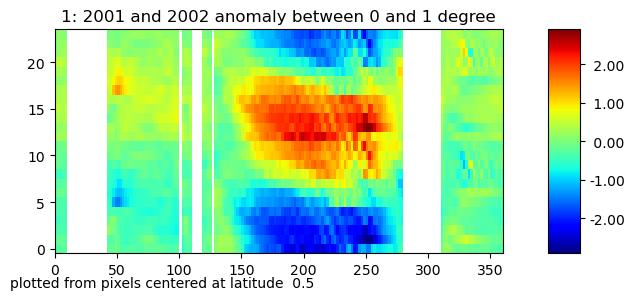

In [18]:
lat_index = 80 
mytitle = "1: 2001 and 2002 anomaly between 0 and 1 degree"
mycaption = "plotted from pixels centered at latitude %4.1f" \
 % lat1d[lat_index]
data2d = anomaly[:,lat_index,:] # a 2D slice 
iwant( data2d[10,100] , 1.48364257812 )
months = range(data2d.shape[0]) # will be an array containing 0,1,...23
plotpixels2(lon1d, months, data2d, title=mytitle,
    outfile = pdir+'Equator.png', caption=mycaption)
# Note for a Hovmoeller diagram, the x coordinate is longitude
# and y coordinate is months. 
# Also, we choose not to specify hic and lowc. 
# plotpixels selects useful values.

1.024139404296875  Value correct!
...doing plotpixels:
min data:  -3.3265380859375    max data: 5.956451416015625
low color bound: -6   high color bound: 6
saved plot to  bunchofplots/FebDiff.png 



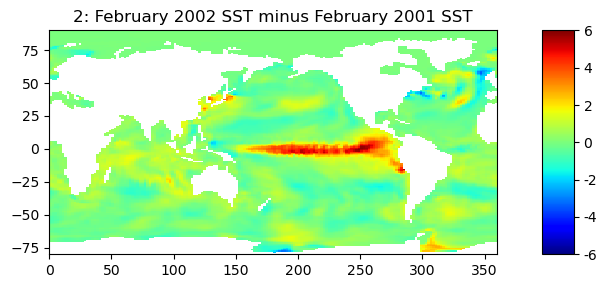

In [19]:
mytitle="2: February 2002 SST minus February 2001 SST"
data2d = sst[13,:,:] - sst[1,:,:] # In Python, February is 1 and 13!
iwant( data2d[85,100] , 1.0241394043  )
plotpixels2(lon1d, lat1d, data2d , hic=6, lowc=-6, 
        title=mytitle, outfile=pdir+'FebDiff.png')

303.30840555826825  Value correct!
...doing plotpixels:
min data:  271.31225713094074    max data: 303.6828422546387
low color bound: 270   high color bound: 305
saved plot to  bunchofplots/AnnualMean.png 



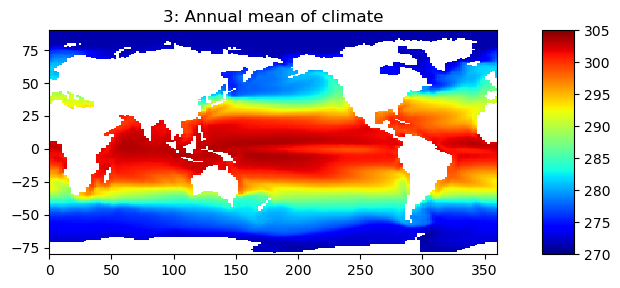

In [20]:
# Hint: .mean(0) is a mean over the 0 index,
# which for climate is ALL the 12 months...
mytitle="3: Annual mean of climate" 
data2d = climate[:,:,:].mean(0)  
iwant( data2d[85,100] , 303.308405558 )
plotpixels2(lon1d, lat1d, data2d, hic=305, lowc=270,
    title=mytitle, outfile=pdir+'AnnualMean.png')

302.75836181640625  Value correct!
...doing plotpixels:
min data:  271.3182423909505    max data: 304.9188181559245
low color bound: 270   high color bound: 305
saved plot to  bunchofplots/JFM.png 



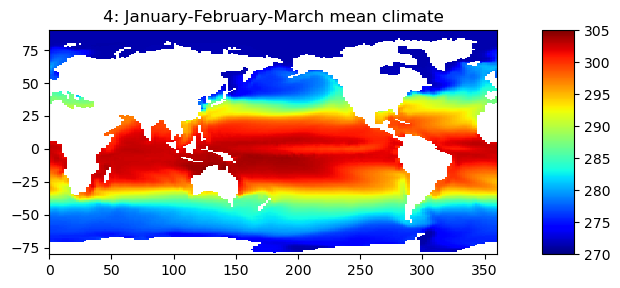

In [21]:
# Similar to above, but use the slice syntax with the .mean method.
mytitle="4: January-February-March mean climate"
data2d = climate[0:3,:,:].mean(0) 
iwant( data2d[85,100] , 302.758361816 )
plotpixels2(lon1d, lat1d, data2d , hic=305, lowc=270,
    title=mytitle, outfile=pdir+'JFM.png')

303.7488606770833  Value correct!
...doing plotpixels:
min data:  271.307612101237    max data: 304.45018513997394
low color bound: 270   high color bound: 305
saved plot to  bunchofplots/JAS.png 



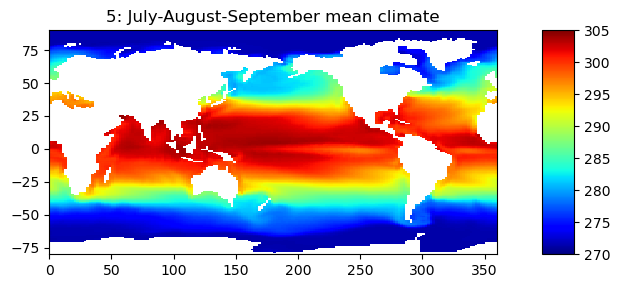

In [22]:
#similar to above
mytitle="5: July-August-September mean climate"
data2d = climate[6:9,:,:].mean(0)
iwant( data2d[85,100] ,303.748860677  )
plotpixels2(lon1d, lat1d, data2d, hic=305, lowc=270,
    title=mytitle, outfile=pdir+'JAS.png')

6: Annual range in climate
1.276123046875  Value correct!
...doing plotpixels:
min data:  0.035888671875    max data: 23.1513671875
low color bound: 0   high color bound: 25
saved plot to  bunchofplots/AnnualRange.png 



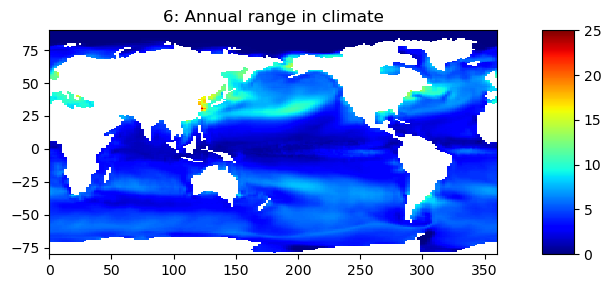

In [23]:
mytitle="6: Annual range in climate"
print(mytitle)
data2d = climate[:,:,:].max(0) - climate[:,:,:].min(0)
iwant( data2d[85,100] , 1.27612304688  )
plotpixels2(lon1d, lat1d, data2d, hic=25, lowc=0,
    title=mytitle, outfile=pdir+'AnnualRange.png')

7: 2001 and 2002 anomaly between 5 S and 5 N
pixel centers from  -4.5 to   4.5
1.070343017578125  Value correct!
...doing plotpixels:
min data:  -2.2411422729492188    max data: 2.2411422729492188
low color bound: -2.2411422729492188   high color bound: 2.2411422729492188
saved plot to  bunchofplots/5S5N.png 



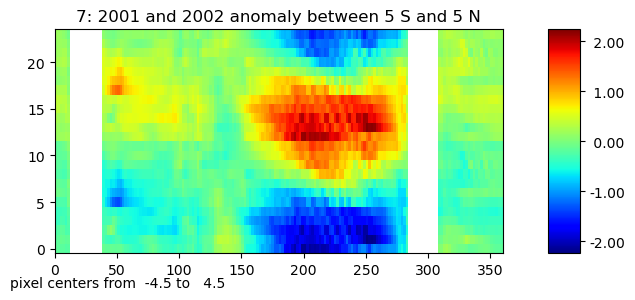

In [24]:
mytitle="7: 2001 and 2002 anomaly between 5 S and 5 N"
print(mytitle)
lia=75 # starting latitude index
lib=85 # ending latitude index
mycaption="pixel centers from %5.1f to %5.1f" % ( lat1d[lia],lat1d[lib-1]) 
print(mycaption)
data2d = anomaly[:,lia:lib,:].mean(1) 
iwant( data2d[10,100] , 1.07034301758 )
months = range(data2d.shape[0])
plotpixels2(lon1d, months, data2d, title=mytitle, caption=mycaption,
    outfile=pdir+'5S5N.png')

## A 1-D plot from METR 1313 
Let's be sure we can make 1-dimensional plots. Just one example here.

the shape of data1d: (24,)


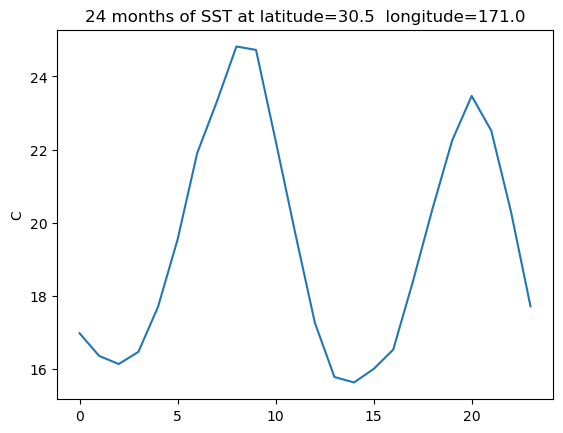

In [26]:
fig,ax = plt.subplots()
lati = 110  
loni = 85
data1d = sst[:,lati,loni] - 273.15 #convert to Celsius
print("the shape of data1d:", data1d.shape )
ax.plot(data1d) # keep it simple
mytitle = "24 months of SST at latitude=%4.1f  longitude=%5.1f" % \
        (lat1d[lati], lon1d[loni])
ax.set_title(mytitle)
ax.set_ylabel('C');

<hr style="height:30px;border:none;background-color:#f00;" />

# Student Tasks

At your password-protected website, you need to offer 3 animations,
like those here http://metr4330.net/~bfiedler/sst.html

To make the animations, use [this code](https://code.activestate.com/recipes/580675-makes-html-with-javascript-to-animate-a-sequence-o). Download the python file and name it `janim.py`. Below I show how to `import janim` as a module and use the function `makeanim`.  It is quite simple.

You might feel your ability with numpy arrays is not stressed in this task. This task is more about basic html, uploading files, including zip files, and manipulating this files with the Linux operating system that hosts your website.  

You may need to know about [how to zip a folder](https://www.wikihow.com/Zip-a-Folder).

You may need to know about [zip and unzip on the Linux command line](http://www.hostingadvice.com/how-to/unzip-file-linuxubuntu/).  

If using MobaXterm from Windows, transferring files and folders can be done by dragging and dropping. No need to zip.

Other tasks in METR 4330/5330 will stress expertise with numpy arrays, so hopefully you acquired some ability in this task, even though such ability was not thoroughly tested.

In [35]:
from janim import makeanim
import glob
from IPython.display import display,clear_output,Image,Markdown
import time as Time

The 3d numpy arrays `sst`, `climate` and `anomaly` were all made above.
You will choose below which one to animate.

Be patient while the loop below runs...

0 2001 1 0000.png
...doing plotpixels:
min data:  271.1732482910156    max data: 304.6780090332031
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0000.png 



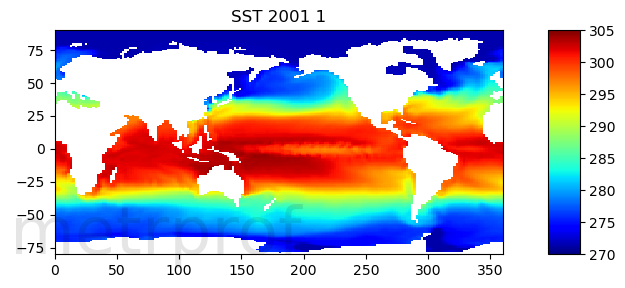

1 2001 2 0001.png
...doing plotpixels:
min data:  271.267333984375    max data: 304.7565612792969
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0001.png 



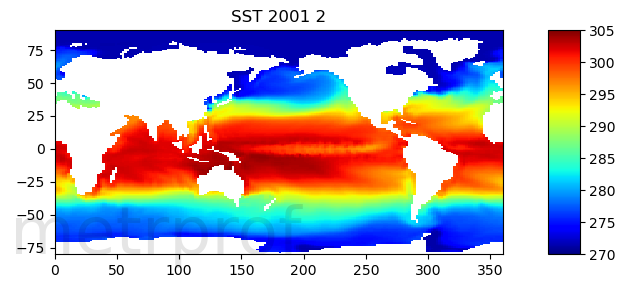

2 2001 3 0002.png
...doing plotpixels:
min data:  271.3099060058594    max data: 304.87493896484375
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0002.png 



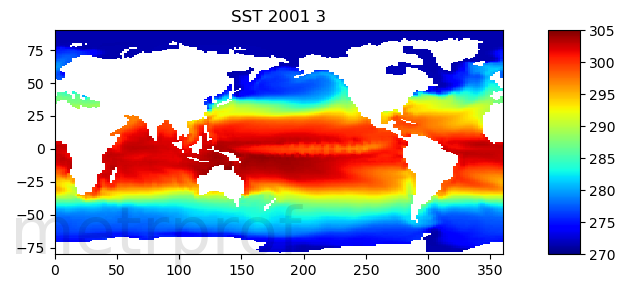

3 2001 4 0003.png
...doing plotpixels:
min data:  271.2795104980469    max data: 304.46075439453125
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0003.png 



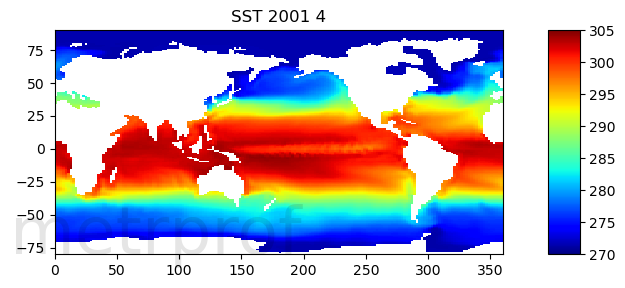

4 2001 5 0004.png
...doing plotpixels:
min data:  271.2388916015625    max data: 304.3373718261719
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0004.png 



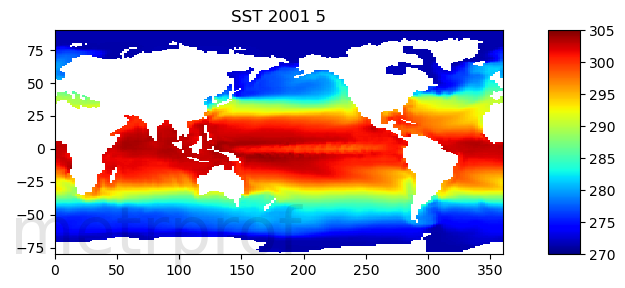

5 2001 6 0005.png
...doing plotpixels:
min data:  271.21539306640625    max data: 304.2770690917969
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0005.png 



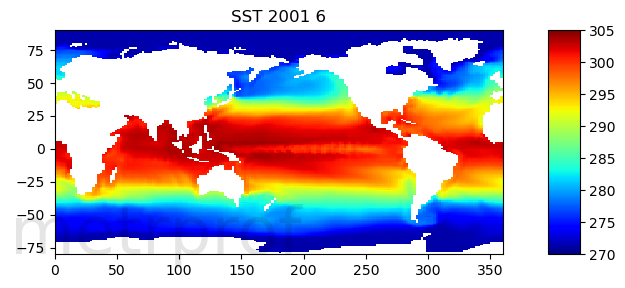

6 2001 7 0006.png
...doing plotpixels:
min data:  271.22003173828125    max data: 304.1467590332031
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0006.png 



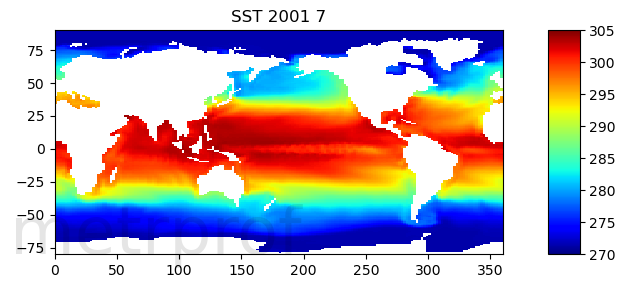

7 2001 8 0007.png
...doing plotpixels:
min data:  271.3025207519531    max data: 304.1699523925781
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0007.png 



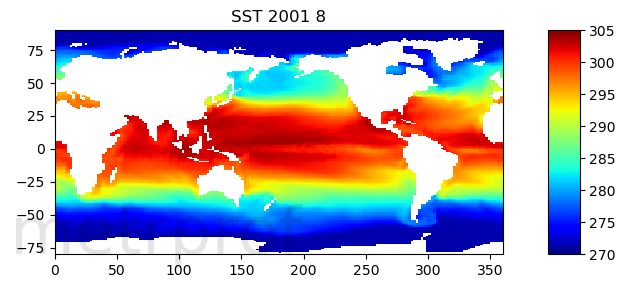

8 2001 9 0008.png
...doing plotpixels:
min data:  271.2986145019531    max data: 304.2428894042969
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0008.png 



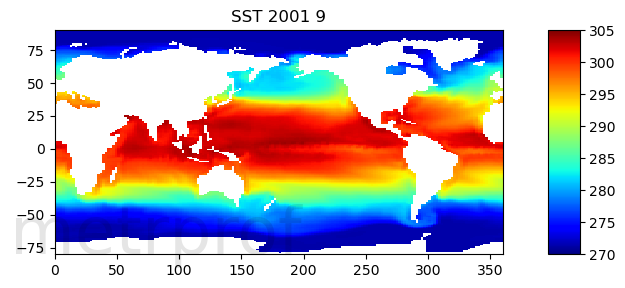

9 2001 10 0009.png
...doing plotpixels:
min data:  271.27484130859375    max data: 304.2436828613281
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0009.png 



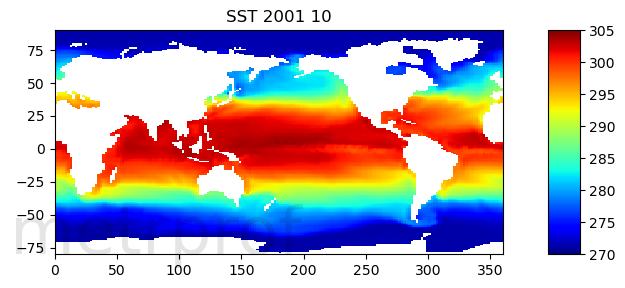

10 2001 11 0010.png
...doing plotpixels:
min data:  271.18609619140625    max data: 303.99346923828125
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0010.png 



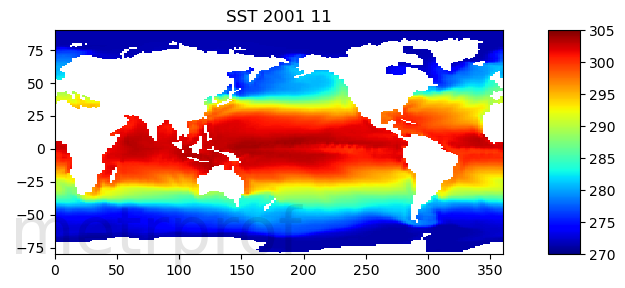

11 2001 12 0011.png
...doing plotpixels:
min data:  271.1708679199219    max data: 304.5306701660156
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0011.png 



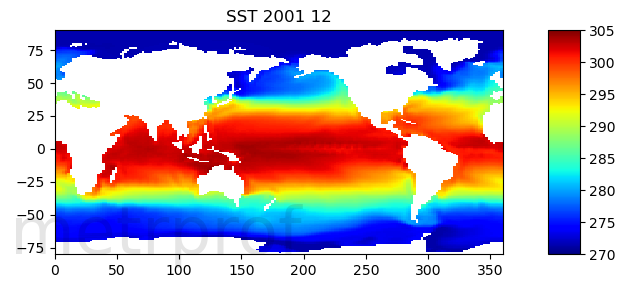

12 2002 1 0012.png
...doing plotpixels:
min data:  271.28057861328125    max data: 305.40960693359375
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0012.png 



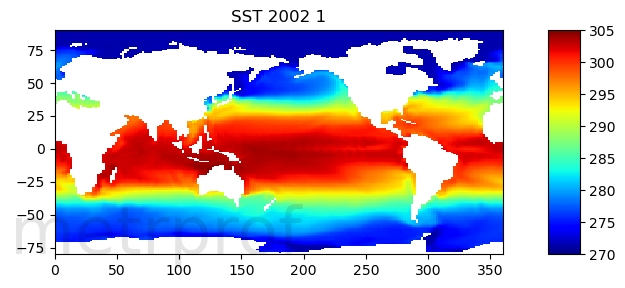

13 2002 2 0013.png
...doing plotpixels:
min data:  271.2713623046875    max data: 305.5037536621094
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0013.png 



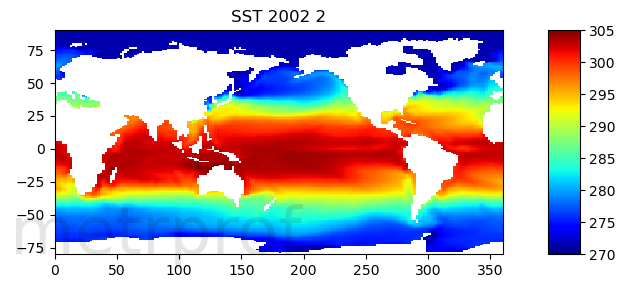

14 2002 3 0014.png
...doing plotpixels:
min data:  271.3326721191406    max data: 304.9760437011719
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0014.png 



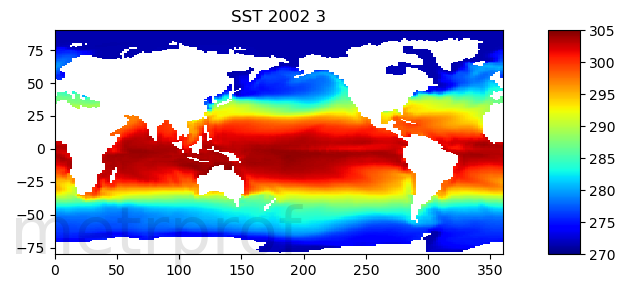

15 2002 4 0015.png
...doing plotpixels:
min data:  271.287841796875    max data: 304.9146423339844
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0015.png 



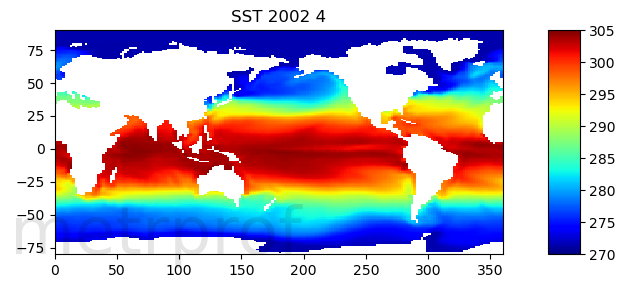

16 2002 5 0016.png
...doing plotpixels:
min data:  271.2433166503906    max data: 304.8323059082031
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0016.png 



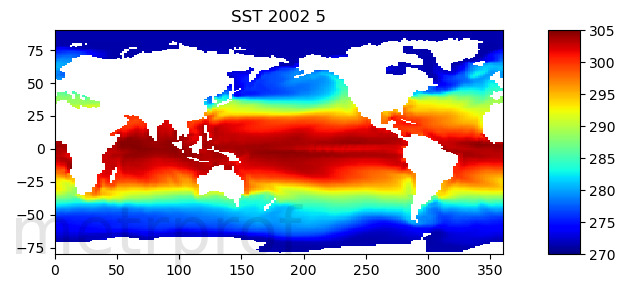

17 2002 6 0017.png
...doing plotpixels:
min data:  271.2168884277344    max data: 305.0819091796875
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0017.png 



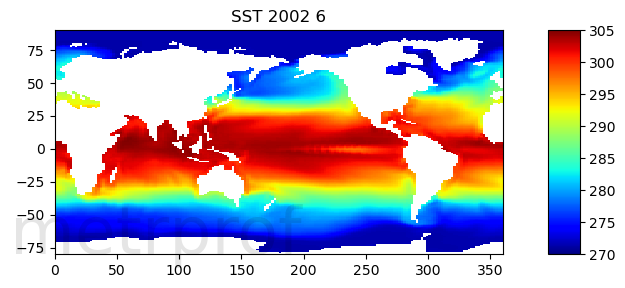

18 2002 7 0018.png
...doing plotpixels:
min data:  271.24737548828125    max data: 304.86090087890625
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0018.png 



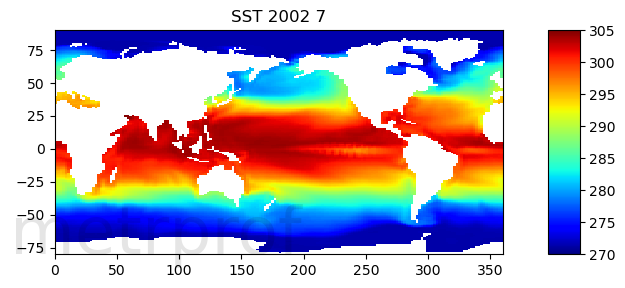

19 2002 8 0019.png
...doing plotpixels:
min data:  271.3087158203125    max data: 305.1409606933594
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0019.png 



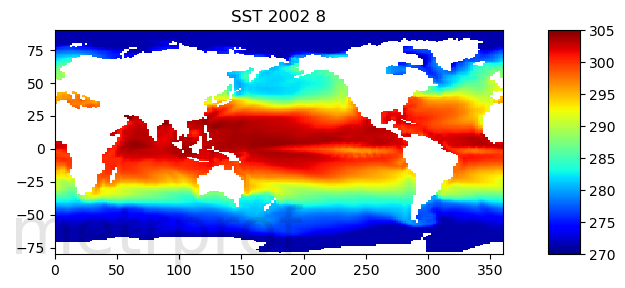

20 2002 9 0020.png
...doing plotpixels:
min data:  271.3016357421875    max data: 305.3996887207031
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0020.png 



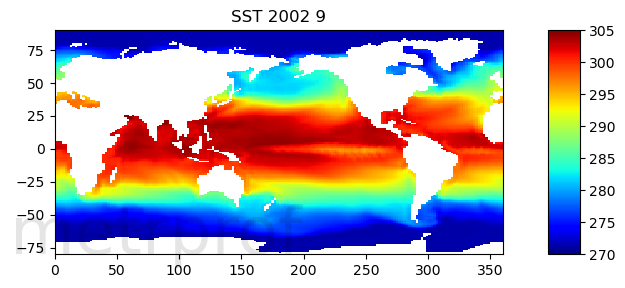

21 2002 10 0021.png
...doing plotpixels:
min data:  271.2607421875    max data: 304.5585632324219
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0021.png 



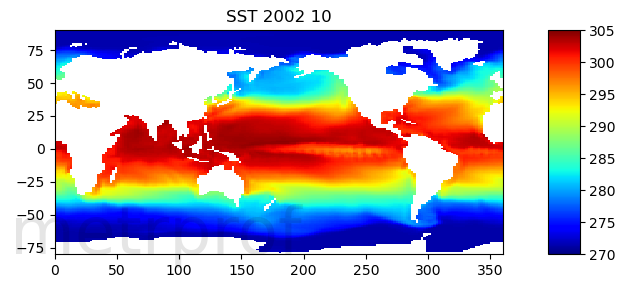

22 2002 11 0022.png
...doing plotpixels:
min data:  271.2061767578125    max data: 304.3849182128906
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0022.png 



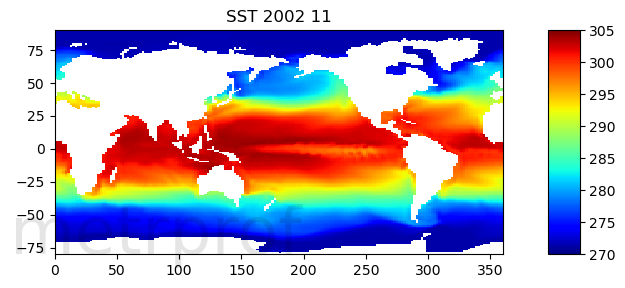

23 2002 12 0023.png
...doing plotpixels:
min data:  271.1903076171875    max data: 305.0431823730469
low color bound: 270   high color bound: 305
saved plot to  sstpngs/0023.png 



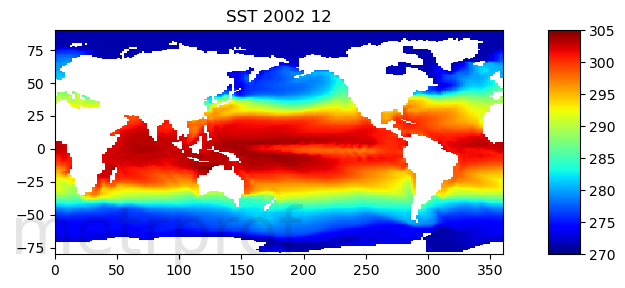

In [37]:
#Select one of the following 3 options:
data3d=sst; pngdir = 'sstpngs/'; animcontrol='sst.html' ; title='SST'; hib=305; lowb=270
#data3d=climate; pngdir = 'climatepngs/'; animcontrol='climate.html' ; title="Climate 2001 thru 2002 for month "; hib=305; lowb=270
#data3d=anomaly; pngdir='anomalypngs/'; animcontrol='anomaly.html'; title="SST anomaly ";hib=6;lowb=-6

if not os.path.exists(pngdir): os.mkdir(pngdir)
nmonths=data3d.shape[0] # will be 24 or 12 
for i in range(nmonths):
    year = 2001 + i//12
    month = i%12 + 1
    if nmonths>12:
        plottitle = title + ' %d %d' % (year, month)
    else:
        plottitle = title + '%d' % (month)
    pngname = '%0.4d.png' % i
    print(i,year,month,pngname)
    data2d=data3d[i,:,:]
    plotpixels2(lon1d, lat1d, data2d, hic=hib, lowc=lowb,
            title = plottitle, outfile=pngdir+pngname, signature='metrprof' ) # your name is not metrprof!

In [39]:
pngs = glob.glob(pngdir+'*.png') # the * matches anything
#if using Windows, get rid of file paths that use \
pngsfixed = [x.replace('\\','/') for x in pngs] # fixes Windows
print(pngs)
print(pngsfixed)

['sstpngs/0007.png', 'sstpngs/0020.png', 'sstpngs/0006.png', 'sstpngs/0008.png', 'sstpngs/0022.png', 'sstpngs/0023.png', 'sstpngs/0009.png', 'sstpngs/0010.png', 'sstpngs/0021.png', 'sstpngs/0013.png', 'sstpngs/0011.png', 'sstpngs/0015.png', 'sstpngs/0017.png', 'sstpngs/0004.png', 'sstpngs/0012.png', 'sstpngs/0016.png', 'sstpngs/0014.png', 'sstpngs/0018.png', 'sstpngs/0001.png', 'sstpngs/0019.png', 'sstpngs/0000.png', 'sstpngs/0002.png', 'sstpngs/0003.png', 'sstpngs/0005.png']
['sstpngs/0007.png', 'sstpngs/0020.png', 'sstpngs/0006.png', 'sstpngs/0008.png', 'sstpngs/0022.png', 'sstpngs/0023.png', 'sstpngs/0009.png', 'sstpngs/0010.png', 'sstpngs/0021.png', 'sstpngs/0013.png', 'sstpngs/0011.png', 'sstpngs/0015.png', 'sstpngs/0017.png', 'sstpngs/0004.png', 'sstpngs/0012.png', 'sstpngs/0016.png', 'sstpngs/0014.png', 'sstpngs/0018.png', 'sstpngs/0001.png', 'sstpngs/0019.png', 'sstpngs/0000.png', 'sstpngs/0002.png', 'sstpngs/0003.png', 'sstpngs/0005.png']


Below, we show how to display, within the notebook, an animation of saved image files.

In [42]:
#locally, we can use the file paths in pngs
pngs.sort() # probably not needed, pngs is already sorted
n=0 #image counter
nloopmax = 1 # set =0 to prevent this cell from running
nloop = 0 #loop counter
while nloop < nloopmax:
    png = pngs[n]
    n+=1
    if n >= len(pngs): #go back to first image
        n = 0
        nloop += 1
    display(Image(filename=png))
    Time.sleep(0.3) # time interval between frames in seconds
    clear_output(wait=True)
print("completed",nloop,"loops of animation")


completed 1 loops of animation


Next we make the HTML file that can animate the png files that you upload to our server.  You will need to make three web pages, one each for `sst` `climate` and `anomaly`

In [44]:
# note we must use pngsfixed here to make the web page
makeanim(pngsfixed,outfile=animcontrol,sortOrder=True, ctlOnSide=True, titlestring=title)
print("your",animcontrol,"was output into the same directory as this notebook")

your sst.html was output into the same directory as this notebook


Now open the html that was just output.  The easiest way to do it is open a new tab in your browser and hit `^O`. 
You can then navigate to the file and click on it.

https://www.thewindowsclub.com/how-to-open-local-files-on-chrome-firefox-edge

Make three such animations, and offer the three animations at your password-protected website.  Do these work for you with the files on your computer? When they do, upload the html files and png directories, and link the html files to your website.
 * [sst.html](sst.html)
 * [climate.html](climate.html)
 * [anomaly.html](anomaly.html)

Ideally, your 3 animations should be easy to navigate, from one to another: http://metr4330.net/~bfiedler/sst.html
You can do that by adding some simple html tags and text to your html files.  There is no need put the animations within your secret directory.  But just make sure I can find the link to them in your secret web page.